In [67]:
import sys
import os
import glob
from skimage import io
from matplotlib import pyplot as plt
from skimage.transform import resize, rotate
from skimage.measure import find_contours, approximate_polygon, regionprops, label
from skimage.color import label2rgb
from skimage.draw import circle_perimeter, rectangle_perimeter, circle
from skimage.util import invert
from skimage import color
from skimage.morphology import closing, opening, disk, erosion, dilation
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
import math 
import numpy as np

In [2]:
# do wersji v1
def get_line_lenght(point1, point2):
    return math.pow((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 , 0.5)
def get_angle_of_line(line):
    (point1, point2) = line
    return math.atan2(point2[1] - point1[1], point2[0] - point1[0]) * 180 / np.pi

def get_angle_to_rotate_image(image):
    thresh = threshold_otsu(image)
    image = image > thresh
    edges = canny(image, sigma=1, low_threshold=False, high_threshold=True)
    min_length = image.shape[0] if image.shape[0] >= image.shape[1] else image.shape[1]
    lines = probabilistic_hough_line(edges, threshold=10, line_length=int(min_length/2),
                                     line_gap=10)

    longest_line = (lines[0],  get_line_lenght(lines[0][0], lines[0][1]))
    for line in lines:
        temp_lenght = get_line_lenght(line[0], line[1])
        if temp_lenght > longest_line[1]:
            longest_line = (line, temp_lenght)

    angle = get_angle_of_line(longest_line[0])
    return angle

In [3]:
# do wersji v2 - nieużywane na razie
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny


def compare_2_numbers_with_range(n1, n2, range=3):
    difference = abs(n1-n2)
    return difference <= range
compare_2_numbers_with_range(5.40, 3.10, 3)

def compare_2_points_with_range(point1, point2, range=3):
    x1, y1 = point1
    x2, y2 = point2
    return compare_2_numbers_with_range(x1, x2, range) and compare_2_numbers_with_range(y1, y2, range)
compare_2_points_with_range((10,20), (8,27), 5)

def check_if_perpendicular_lines(line1, line2):
    point11, point12 = line1
    point21, point22 = line2
    if compare_2_points_with_range(point11, point21, 10) or compare_2_points_with_range(point11, point22, 10) or compare_2_points_with_range(point12, point21, 10):     
        angle_between_lines = abs(get_angle_of_line(line1)-get_angle_of_line(line2))
        if compare_2_numbers_with_range(angle_between_lines, 90, 5):
            return True
    
    return False

# def check_if_parallel_lines(line1, line2):
#     point11, point12 = line1
#     point21, point22 = line2
#     if compare_2_points_with_range(point11, point21, 10) or compare_2_points_with_range(point11, point22, 10) or compare_2_points_with_range(point12, point21, 10):     
#         angle_between_lines = abs(get_angle_of_line(line1)-get_angle_of_line(line2))
#         if compare_2_numbers_with_range(angle_between_lines, 0, 5):
#             return True
    
    return False

def get_base_line(image):
    thresh = threshold_otsu(image)
    image = image > thresh
    edges = canny(image, sigma=1, low_threshold=False, high_threshold=True)
    min_length = image.shape[0] if image.shape[0] >= image.shape[1] else image.shape[1]
    lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                     line_gap=10)
    possible_baselines = list()
    for line1 in lines:
        counter = 0
        for line2 in lines:
#             if check_if_parallel_lines(line1, line2):
#                 continue
            if check_if_perpendicular_lines(line1, line2):
                counter += 1
        if counter >= 2:
            possible_baselines.append(line1)
            
    if len(possible_baselines) == 0:
        return None

    longest_line = possible_baselines[0]
    longest_distance = get_line_lenght(possible_baselines[0][0],possible_baselines[0][1])
    for line in possible_baselines[1:]:
        temp = get_line_lenght(line[0], line[1])
        if temp > longest_distance:
            longest_distance = temp
            longest_line = line
    
    return longest_line



In [144]:
# do wersji v3 - szukanie punktów skrajnych
def get_extreme_points(image):
    
    contour = find_contours(image, level=3)[0]
    detected_points = approximate_polygon(contour, tolerance=2)
    minHeight = image.shape[0]-1
    maxHeight = 0 
    minWidth = image.shape[1]-1 
    maxWidth = 0 
    for height, width in detected_points:
        if height <= minHeight:
            minHeight = height
        if width <= minWidth:
            minWidth = width
            
        if height >= maxHeight:
            maxHeight = height
        if width >= maxWidth:
            maxWidth = width
            
    print(minHeight, maxHeight, minWidth, maxWidth)
    extreme_points = set()
    image = color.grey2rgb(image)
    for height, width in detected_points:  
        if height == minHeight or height == maxHeight or width == minWidth or width == maxWidth:
            rr, cc = circle_perimeter(int(height),int(width), 3)
            image[rr, cc] = [255,0,0]
            extreme_points.add((height, width))
        
    return image, extreme_points

# image = io.imread(images_paths[5])
# io.imshow(image[50-10:50+10,5-10:5+10])
# image, p = get_extreme_points(image) 
# print(p)
# io.imshow(image)

def clamp(n, smallest, largest): 
    return max(smallest, min(n, largest))
def check_if_it_is_right_angle(image, point, radius=10):
    (height, width) = point
    height = int(height)
    width = int(width)
    (image_height, image_width) = image.shape
    
    right_width_min = clamp(width-radius-1, 0, image_width)
    right_width_max = clamp(width+radius+1, 0, image_width)
    right_height_min = clamp(height-radius-1, 0, image_height)
    right_height_max = clamp(height+radius+1, 0, image_height)
    print(right_width_min, right_width_max, right_height_min, right_height_max)
    slice_of_image = image[right_height_min:right_height_max, right_width_min:right_width_max]
    
#     thresh = threshold_otsu(slice_of_image)
    thresh = 127
    slice_of_image = slice_of_image > thresh
    
    labeled = label(slice_of_image)
    print(point)
    print(len(labeled))
    props = regionprops(labeled)
    white_area = props[0].area
    black_area = (radius*2+1)**2-white_area
    
    white_to_black_ratio = white_area/(white_area+black_area)

    print(white_area)
    print(black_area)
    print(white_to_black_ratio)
    print("=========================")
    return True if compare_2_numbers_with_range(0.25, white_to_black_ratio, 0.03) else False

# image = io.imread(images_paths[5])
# print(check_if_it_is_right_angle(image, (67,6.18), radius=30))

def get_points_with_right_angle(image):
    contour = find_contours(image, level=10)[0]
    print(len(contours))
    appr_pol = approximate_polygon(contour, tolerance=5)
    
    points_with_right_angle = set()
    for c in appr_pol:
        if check_if_it_is_right_angle(image=image, point=(c[0],c[1]), radius=30):
            points_with_right_angle.add((c[0],c[1]))
    
    return points_with_right_angle

print(get_points_with_right_angle(io.imread(images_paths[0])))

1
99 161 172 209
(203.5, 130.0)
37
975
2746
0.2620263370061811
0 35 63 125
(94.0, 4.285714285714286)
62
866
2855
0.23273313625369524
51 113 0 35
(4.625, 82.0)
35
536
3185
0.14404729911314162
55 117 0 53
(22.113636363636363, 86.0)
53
1612
2109
0.4332168771835528
63 125 0 52
(21.0, 94.7872340425532)
52
1409
2312
0.3786616500940607
62 124 0 61
(30.294117647058822, 93.0)
61
1863
1858
0.50067186240258
87 149 5 67
(36.0, 118.87179487179488)
62
896
2825
0.24079548508465468
71 133 57 119
(88.0, 102.71428571428571)
62
2605
1116
0.7000806234883096
95 157 67 129
(98.0, 126.73684210526316)
62
1233
2488
0.3313625369524321
88 150 99 161
(130.0, 119.79591836734694)
62
3157
564
0.848427841977963
132 194 78 140
(109.10958904109589, 163.0)
62
1196
2525
0.32141897339424885
136 198 87 149
(118.00904977375566, 167.0)
62
1551
2170
0.416823434560602
155 214 83 145
(114.0, 186.98224852071007)
62
889
2832
0.2389142703574308
148 210 105 167
(136.13333333333333, 179.0)
62
1609
2112
0.4324106423004569
170 214 89 

In [135]:
from skimage.segmentation import clear_border
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
def clear_images(images):
    images_cleared = list()
    for img in images:
        thresh = threshold_otsu(img)
        bw = closing(img > thresh, square(3))
        cleared = clear_border(bw)
        images_cleared.append(cleared)
    return images_cleared

def rotate_images(images):
    images_rotated = list()
    for img in images:
        angle = get_angle_to_rotate_image(img)
        img = rotate(img, angle).astype(np.uint8)
        images_rotated.append(img)
    return images_rotated

def resize_images(images):  
    max_height, max_width = images[0].shape
    for image in images:
        if image.shape[0] > max_height:
            max_height = image.shape[0]
        if image.shape[1] > max_width:
            max_width = image.shape[1]
#     shape = (longest_height, longest_width)
#     images_resized = [(resize(img, shape)*255).astype(np.uint8) for img in images]
    
    images_resized = list()
    for image in images:
        scale = max_width/image.shape[1]
        new_shape = (int(image.shape[0]*scale), int(image.shape[1]*scale))
        resized_image = (resize(image, new_shape)*255).astype(np.uint8)
        images_resized.append(resized_image)
    
    return images_resized

def cut_images_sides(images):
    images_rect = list()
    images_cut = list()
    for img in images:
#         thresh = threshold_otsu(img)
#         bw = closing(img > thresh, square(3))
#         img = clear_border(bw)
        
        label_img, num = label(img, connectivity=2, return_num=True, background=0)
        region_props = regionprops(label_img)
#         print(num)
#         print(region_props[0].bbox)
        biggest_region = region_props[0]
        for region in region_props:
            if region.area > biggest_region.area:
                biggest_region = region

#         x,y = rectangle_perimeter((1,biggest_region.bbox[1]), (img.shape[0]-2,biggest_region.bbox[3]))
#         x,y = rectangle_perimeter((biggest_region.bbox[0], biggest_region.bbox[1]), (biggest_region.bbox[2], biggest_region.bbox[3]))
#         img = color.grey2rgb(img)
#         img[x,y] = [255,0,0]
#         images_rect.append(img)
#         images_cut.append(img[:,biggest_region.bbox[1]:biggest_region.bbox[3]+1])
        images_cut.append(img[biggest_region.bbox[0]:biggest_region.bbox[2],biggest_region.bbox[1]:biggest_region.bbox[3]+1])

        
    return images_cut

In [5]:
# wersja używa najdłuższej linii w figurze jako podstawy, nie zawsze będzie działało dla późniejszych przykałdów
def rotate_scale_and_cut_v1(images_paths):
    images = [io.imread(path) for path in images_paths]
    images = rotate_images(images)
    images = cut_images_sides(images)
    images = resize_images(images)
    images = [img*255 for img in images]
    images = [opening(closing(img, disk(9)), disk(9)) for img in images]
#     for img in images:
#         labeled = label(invert(img))
#         props = regionprops(labeled)
#         print(len(props))
#     images = [invert(img) for img in images]   
    return images

# wersja szuka linii, które mają kąt prosty jako podstawa, działa słabiej
def rotate_and_scale_v2(images_paths):
    images_new = list()
    images = [io.imread(path) for path in images_paths]
    for i, image in enumerate(images):
        base_line = get_base_line(image)
        if base_line == None:
            images_new.append(image)
            print('Nie znaleziono podstawy dla obrazka numer (indeks w tablicy): ', i )
            continue
        angle = get_angle_of_line(base_line)
        img = rotate(image, angle)
        images_new.append(img)
        
    images_new = cut_images_sides(images_new)
    images_new = resize_images(images_new)
    images_new = [opening(closing(img, disk(9)), disk(9)) for img in images_new]
    return images_new

# def rotate_and_scale_v3(images_paths):
#     images_changed = list()
#     images = [io.imread(path) for path in images_paths]
#     for image in images:
        
# #     images_new = cut_images_sides(images_new)
# #     images_new = resize_images(images_new)
# #     images_new = [opening(closing(img, disk(9)), disk(9)) for img in images_new]
#     return images_changed

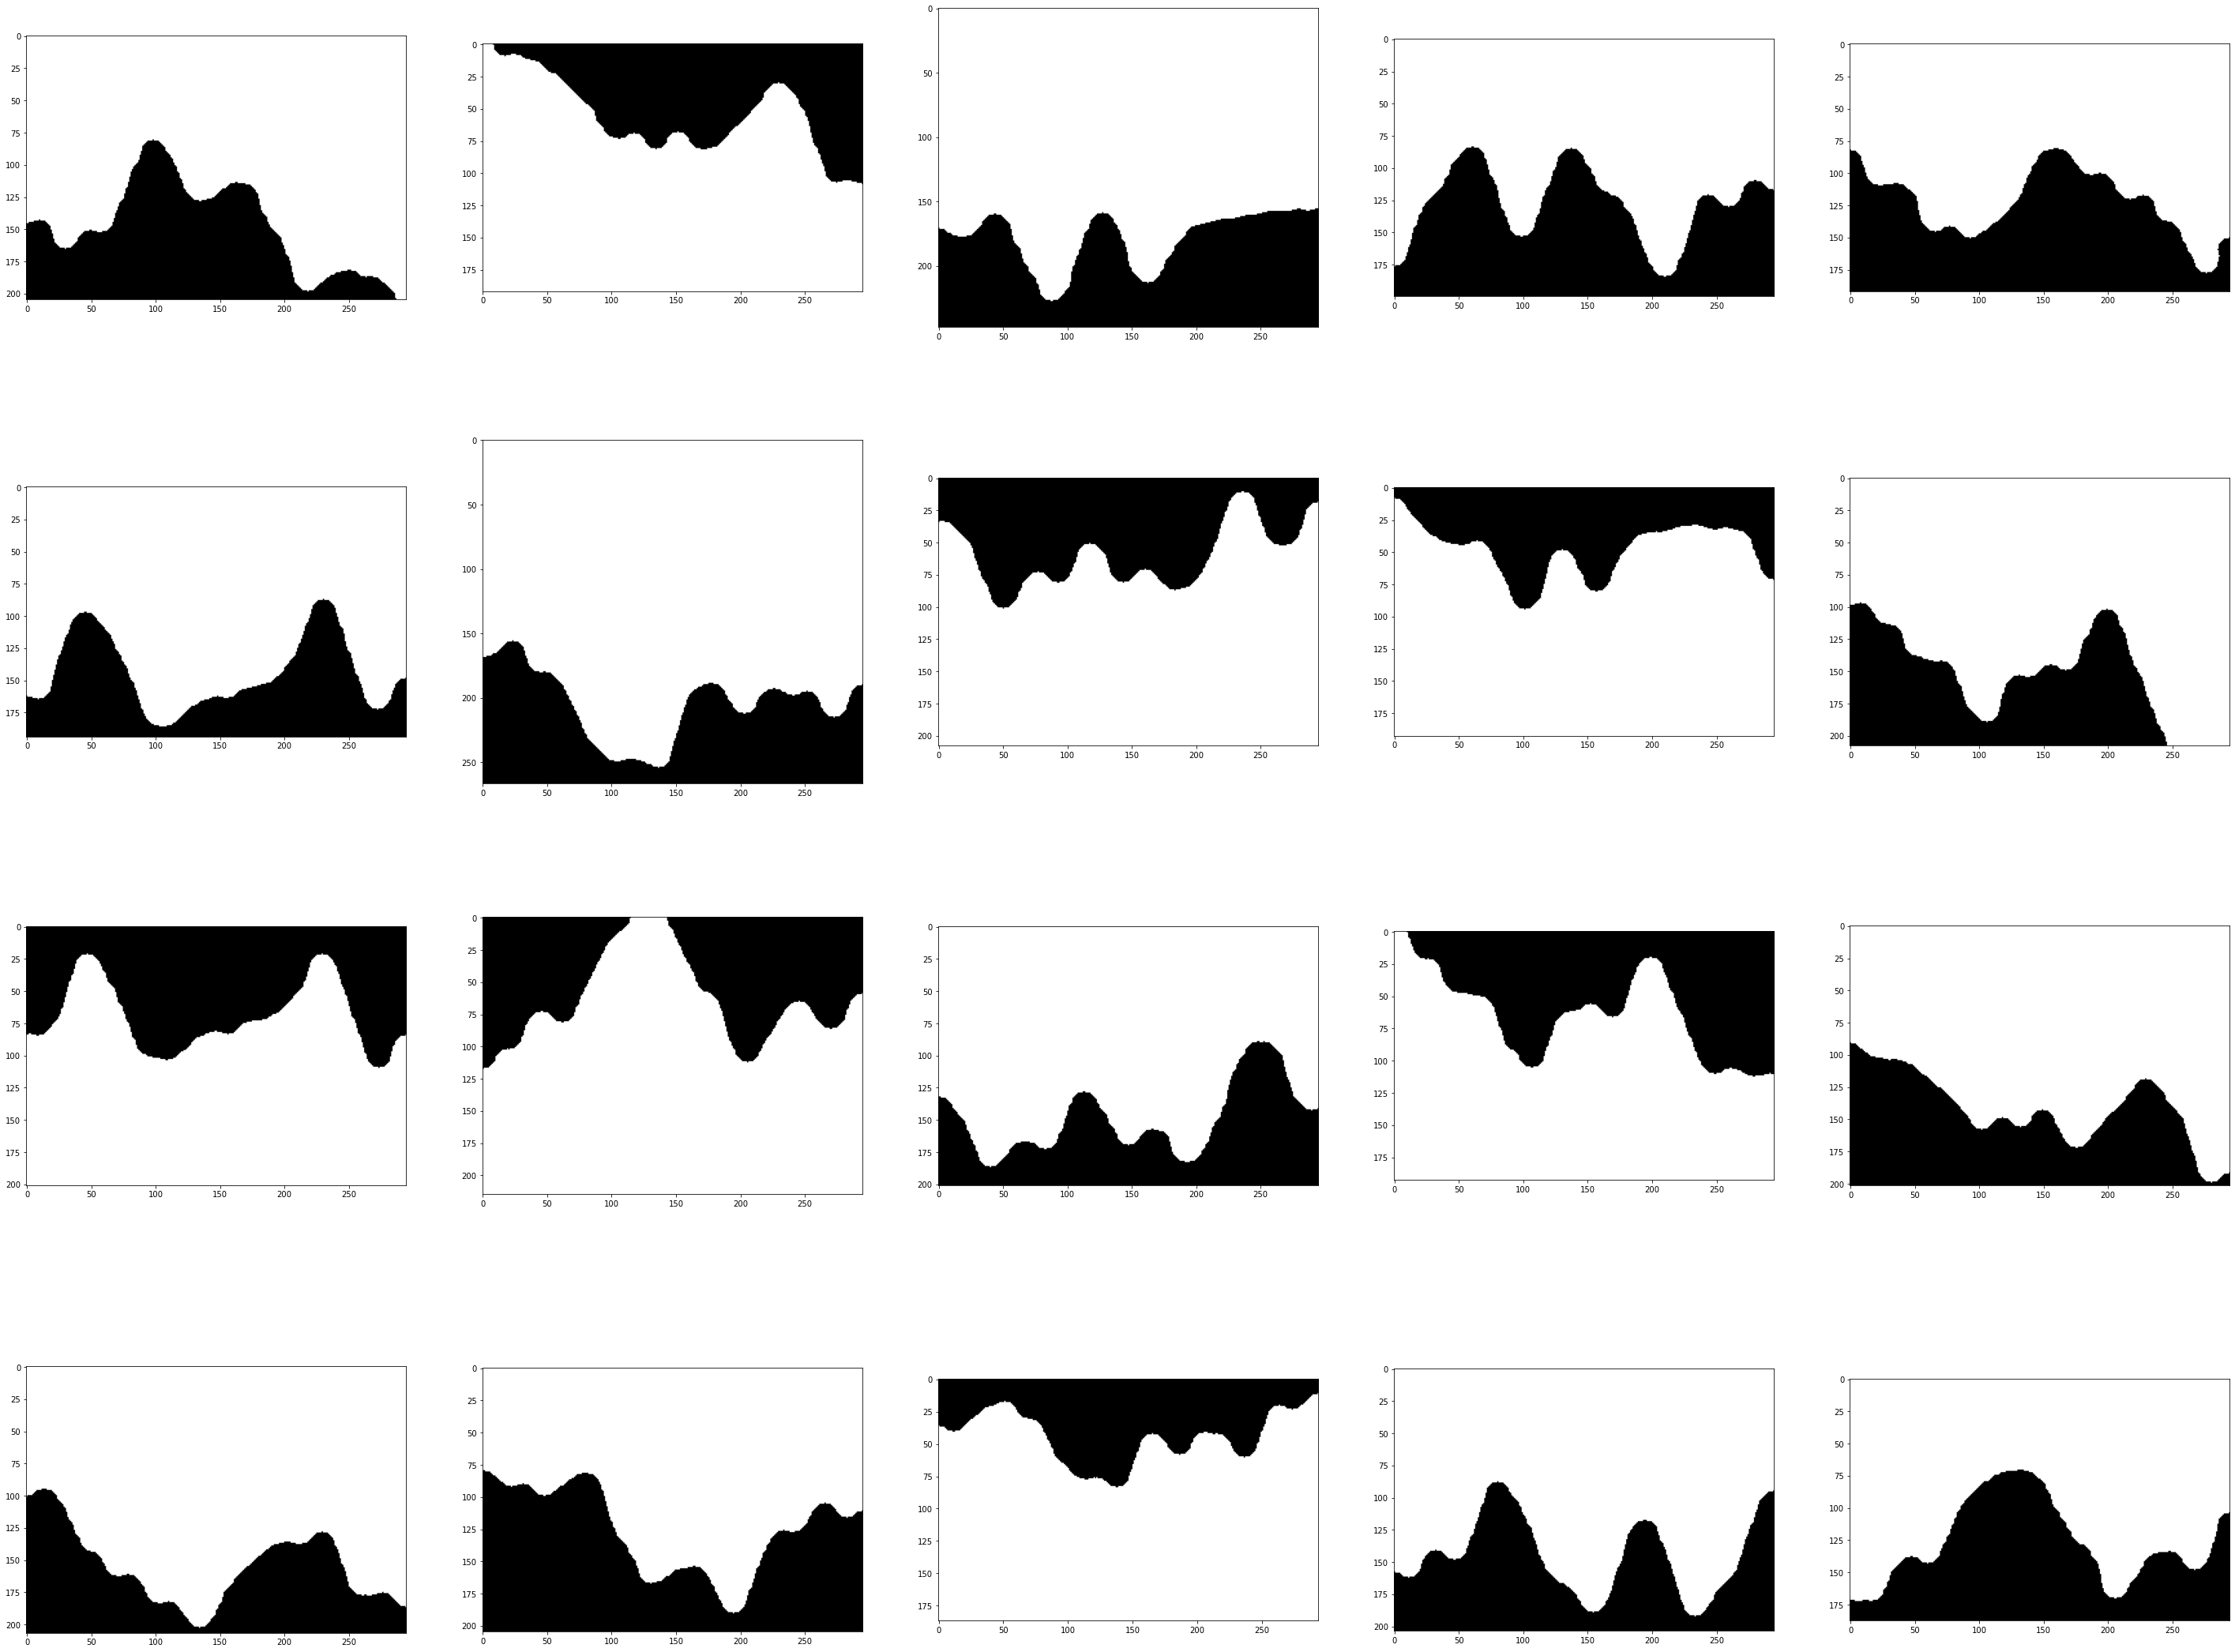

In [9]:
n_of_cases = 5
path = os.path.join('D:\Dokumenty\Projekty\PIRO/project1/proj1_daneA\set1', '')
images_paths = glob.glob(os.path.join(path, '*.png'))

images = rotate_scale_and_cut_v1(images_paths)

fig = plt.figure(figsize=(50,50))
columns = 5
rows = (len(images_paths)/columns)+1
for i, img in enumerate(images):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap=plt.cm.gray)


(193, 294)


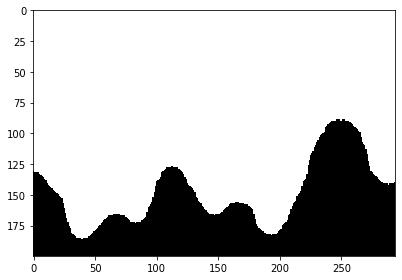

In [7]:
print(images[5].shape)
io.imshow(images[12])

(200, 294)


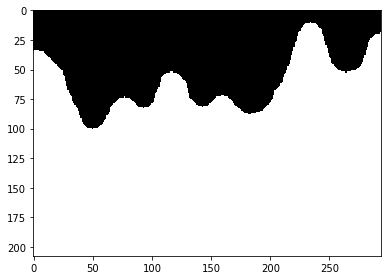

In [8]:
print(images[10].shape)
io.imshow(images[7])

1
(209, 214, 3)
203.5 130.0
94.0 4.285714285714286
4.625 82.0
22.113636363636363 86.0
21.0 94.7872340425532
30.294117647058822 93.0
36.0 118.87179487179488
88.0 102.71428571428571
98.0 126.73684210526316
130.0 119.79591836734694
109.10958904109589 163.0
118.00904977375566 167.0
114.0 186.98224852071007
136.13333333333333 179.0
120.0 201.95384615384614
203.5 130.0


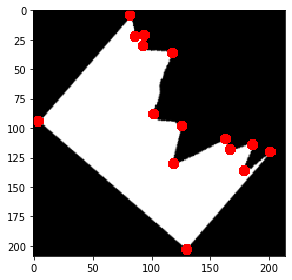

In [141]:
# przykład znajdowania punktów (kątów w sumie nwm)
img = io.imread(images_paths[0])
contours = find_contours(img, level=10)
img = color.grey2rgb(img)
print(len(contours))
print(img.shape)
for n, contour in enumerate(contours):
    appr_pol = approximate_polygon(contour, tolerance=5)
    for c in appr_pol:
        print(c[0], c[1])
        x,y = circle(int(c[0]),int(c[1]), 5)
        img[x,y] = [255,0,0]
        
io.imshow(img)